In [18]:
import numpy as np
import itertools as it

In [19]:
B = [[-1000,1000],[-1000,1000]] #Bounds (x,y)
P = [4,4] #Precision
dirs = [-1,-1] #Direction of objectives (-1: min, +1: max)
S = range(1000) #Iterations
Cr = 0.6; #Crossover rate
Mu = 0.2; #Mutation rate
cT = 10 #Population size

In [20]:
T = range(cT) #Population set
M = range(len(dirs)) #Objectives
D = range(len(B)) #Dimension
I = {d: range(int(np.floor(np.log2((B[d][1]-B[d][0])*10**P[d])))+1) for d in D} #Chromosome length

In [21]:
def evaluate(x,y, m):
    objs = {0: x**2+y**2, 
            1: (x-2)**2+(y-2)**2}
    if m==0: return objs[0]
    if m==1: return objs[1]


In [22]:
M_a = None
gP_a = None
C_a = None
P_a = None

In [23]:
#Encoding
a = {d: {(t,i): np.random.choice([0,1]) for t,i in it.product(T,I[d])} for d in D}

In [24]:
for s in S:
    
    #Decoding
    x = {d: {t: B[d][0]+ ((sum((2**i)*a[d][(t,i)] for i in I[d]))/((2**len(I[d]))-1))*(B[d][1]-B[d][0]) for t in T} for d in D}
    
    #Evaluation
    g = {m: {t: evaluate(x[0][t],x[1][t], m) for t in T} for m in M}

    #Merging Population
    if s!=0:
        gC_a=[[g[m][t] for t in T] for m in M]
        M_a=np.concatenate((C_a, P_a), axis=1)
        M_ga=np.concatenate((gC_a, gP_a), axis=1) 
        T = range(2*cT)
        a={d: {(t,i): int(M_a[d][t][i]) for t,i in it.product(T,I[d])} for d in D}
        g = {m: {t: M_ga[m][t] for t in T} for m in M}
        
    #Detecting Front Layers
    front = {l: set() for l in T} 
    d_set = {t: set() for t in T} 
    d_count = {t:  0 for t in T} 
    rank = {t:  0 for t in T} 
    for t in T:
        d_set[t] = set()
        d_count[t] = 0
        for tt in T:
            if all(dirs[m]*g[m][t] >= dirs[m]*g[m][tt] for m in M) and any(dirs[m]*g[m][t] > dirs[m]*g[m][tt] for m in M):
                d_set[t].add(tt)
            elif all(dirs[m]*g[m][t] <= dirs[m]*g[m][tt] for m in M) and any(dirs[m]*g[m][t] < dirs[m]*g[m][tt] for m in M):
                d_count[t]+=1
        if d_count[t]==0:
            rank[t]==0
            front[0].add(t)
    l=0
    while(len(front[l])!=0):
        next_l=set()
        for t in front[l]:
            for tt in d_set[t]:
                d_count[tt] = d_count[tt] - 1
                if(d_count[tt]==0): rank[tt]=l+1; next_l.add(tt)
        l = l+1
        front[l]=next_l
    front = {key:value for key,value in front.items() if value}

    #Calculate Crowding Distances
    sort = {m: {l: [x for _,x in sorted(zip([g[m][t] for t in front[l]],front[l]))] for l in front} for m in M}
    cd = {l: [sum((g[m][sort[m][l][i+1]]-g[m][sort[m][l][i-1]])/(max(g[m])-min(g[m])) for m in M) if i not in {0,len(front[l])-1} else np.inf for i in range(len(front[l]))] for l in front} 
    
    #Truncating Pareto Archive
    indices = []
    count = 0
    max_cap = cT
    for l in front:
        count += len(front[l])
        if count <= max_cap:
            for t in front[l]:
                indices.append(t)
        else:
            capacity=max_cap-len(indices)
            if capacity==0: break
            else:
                sort = [x for _,x in sorted(zip(cd[l],front[l]), reverse=True)]
                for t in sort:
                    indices.append(t)
                    capacity-=1
                    if capacity==0: break
    
    #Defining Parent Population
    T = set(indices)
    a = {d: {(t,i): a[d][(t,i)] for t,i in it.product(T,I[d])} for d in D}
    gP_a=[[g[m][t] for t in T] for m in M]
    P_a=[[[a[d][(t,i)] for i in I[d]] for t in T] for d in D]
 
    #Crossover
    aa = a.copy()
    r = {t: np.random.rand() for t in T}
    cross = {(t,tt): 1 if r[t] < Cr and r[tt] < Cr and t<tt else 0 for t,tt in it.product(T,T)}
    pos = {d: {(t,tt): np.random.randint(0,len(I[d])-1) if cross[(t,tt)]==1 else 0 for t,tt in it.product(T,T) } for d in D}
    a = {d: {(t,i): aa[d][(tt,i)] if cross[(t,tt)]==1 and t<tt else aa[d][(tt,i)] if cross[(tt,t)]==1 and t>tt else aa[d][(t,i)] for t,tt in it.product(T,T) for i in range(pos[d][(t,tt)],len(I[d]),1)} for d in D}
  
    #Mutation
    r = {d: {(t,i): np.random.rand() for t,i in it.product(T,I[d])} for d in D}
    a = {d: {(t,i): 1 if aa[d][(t,i)]==0 and r[d][(t,i)]<Mu else 0 if r[d][(t,i)]<Mu else aa[d][(t,i)] for t,i in it.product(T,I[d])} for d in D}

    #Defining Child Population
    C_a=[[[a[d][(t,i)] for i in I[d]] for t in T] for d in D]

In [25]:
M

range(0, 2)

In [29]:
# %load /Users/hoaidang/Desktop/Study/heuristics_optimization_in_python/visualization/visual_multi_obj.py
import matplotlib.pyplot as plt
import numpy as np


def plot_landscape(m, B):
    x = np.linspace(B[0][0], B[0][1], 30)
    y = np.linspace(B[1][0], B[1][1], 30)
    X, Y = np.meshgrid(x, y)
    Z = evaluate(X, Y, m)
    plt.figure(m, dpi=1200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='viridis',edgecolor='none')

def plot_front(gP_a):
    plt.figure(dpi=1200)
    plt.scatter(gP_a[0],gP_a[1])
    
def report_front(gP_a, cT, P_a, B, D, I):
    print('Objective values =', gP_a)
    T = range(cT)
    x = [ [ B[d][0]+ ((sum((2**i)*P_a[d][t][i] for i in I[d]))/((2**len(I[d]))-1))*(B[d][1]-B[d][0]) for t in T] for d in D]
    print('Solution values =', x)


Objective values = [[0.025210905089670266, 2.8503852800607405, 1.4447517199972837, 3.024946313879476, 2.7564603355250537, 0.052124979442115534, 0.39126490159563065, 2.4186507697203856, 2.8504654648133942, 0.46410583922240634], [7.41748192884811, 4.141763101368574, 4.665174322305929, 4.081958664945554, 4.214015911418874, 7.158770536924468, 6.15775958600855, 4.234311062097219, 4.103457893741731, 5.745418700704044]]
Solution values = [[0.15863776679748298, 1.6882718112549355, 1.2019575000392706, 1.7392337840567507, 1.66007881343603, 0.22825599396992402, 0.6222427076769463, 1.5551746355049545, 1.68833141590153, 0.6812513077632047], [-0.006705522737092906, -0.011116266581893797, -0.0070631506164318125, -0.0034868718232701212, -0.02446770740948523, -0.00491738334051206, -0.06386637878017609, -0.009089708599162805, -0.0015795231336142024, -0.0015795231336142024]]
Objective values = [[0.025210905089670266, 2.8503852800607405, 1.4447517199972837, 3.024946313879476, 2.7564603355250537, 0.0521249

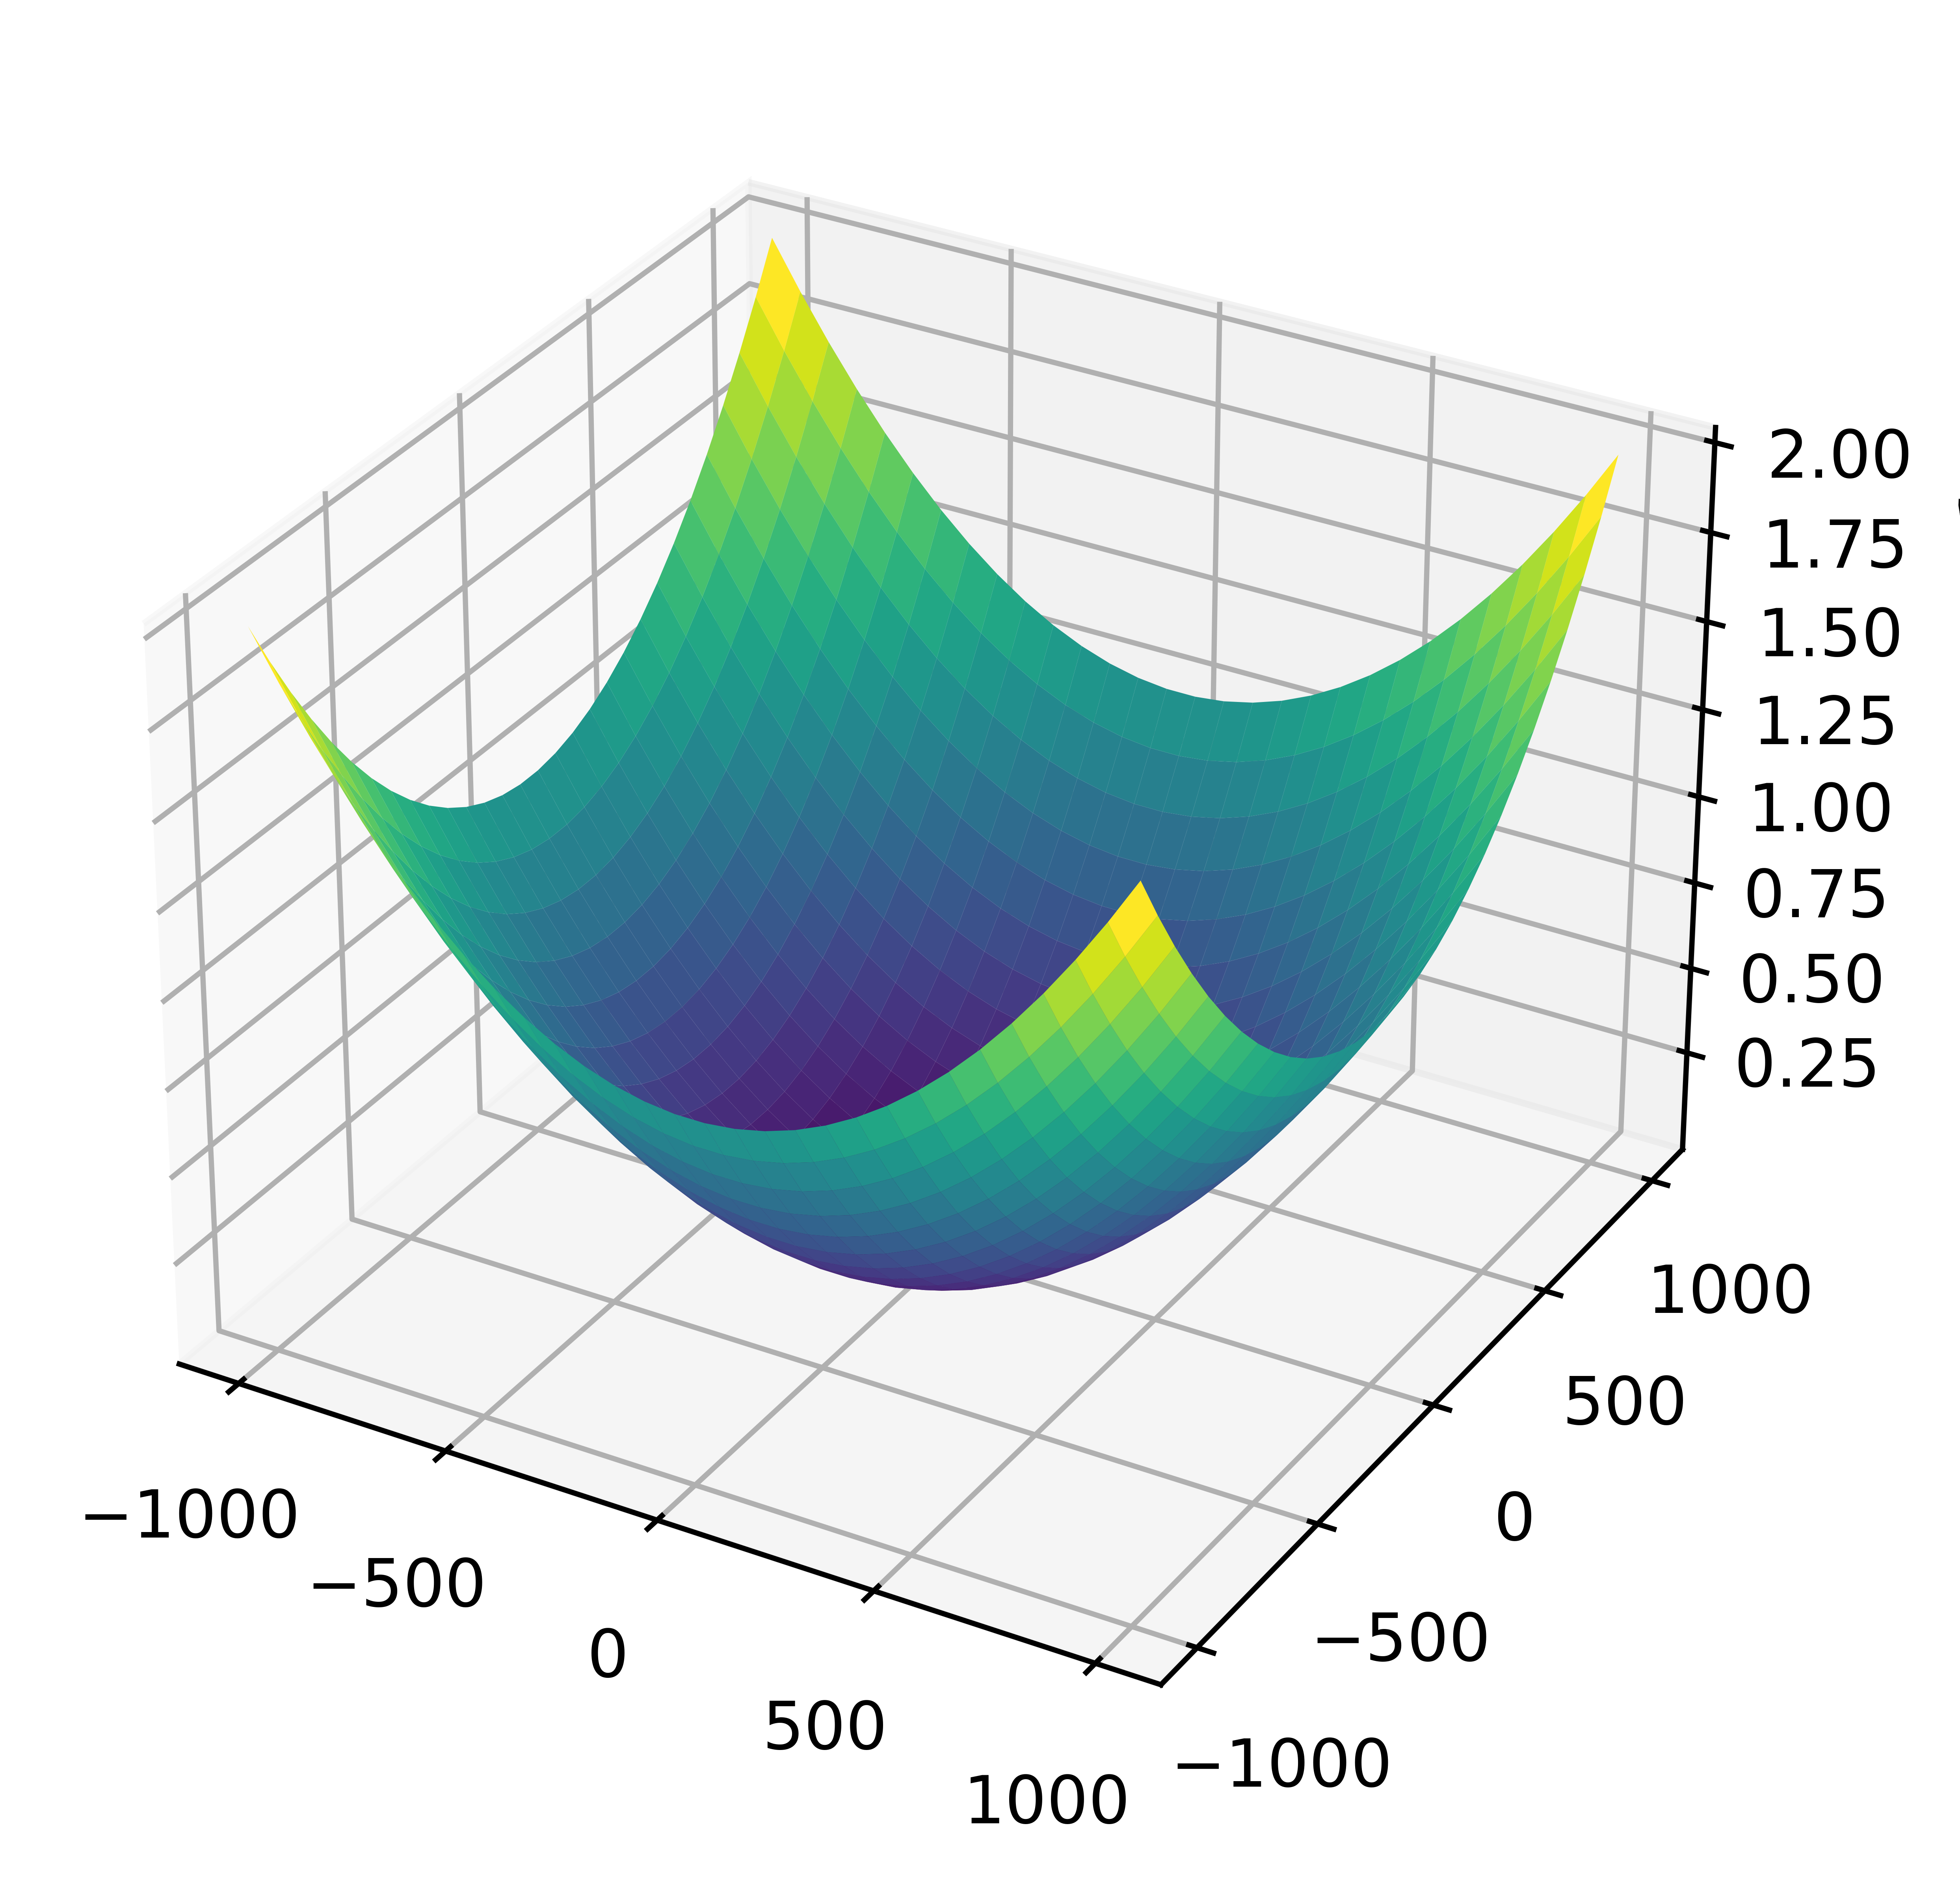

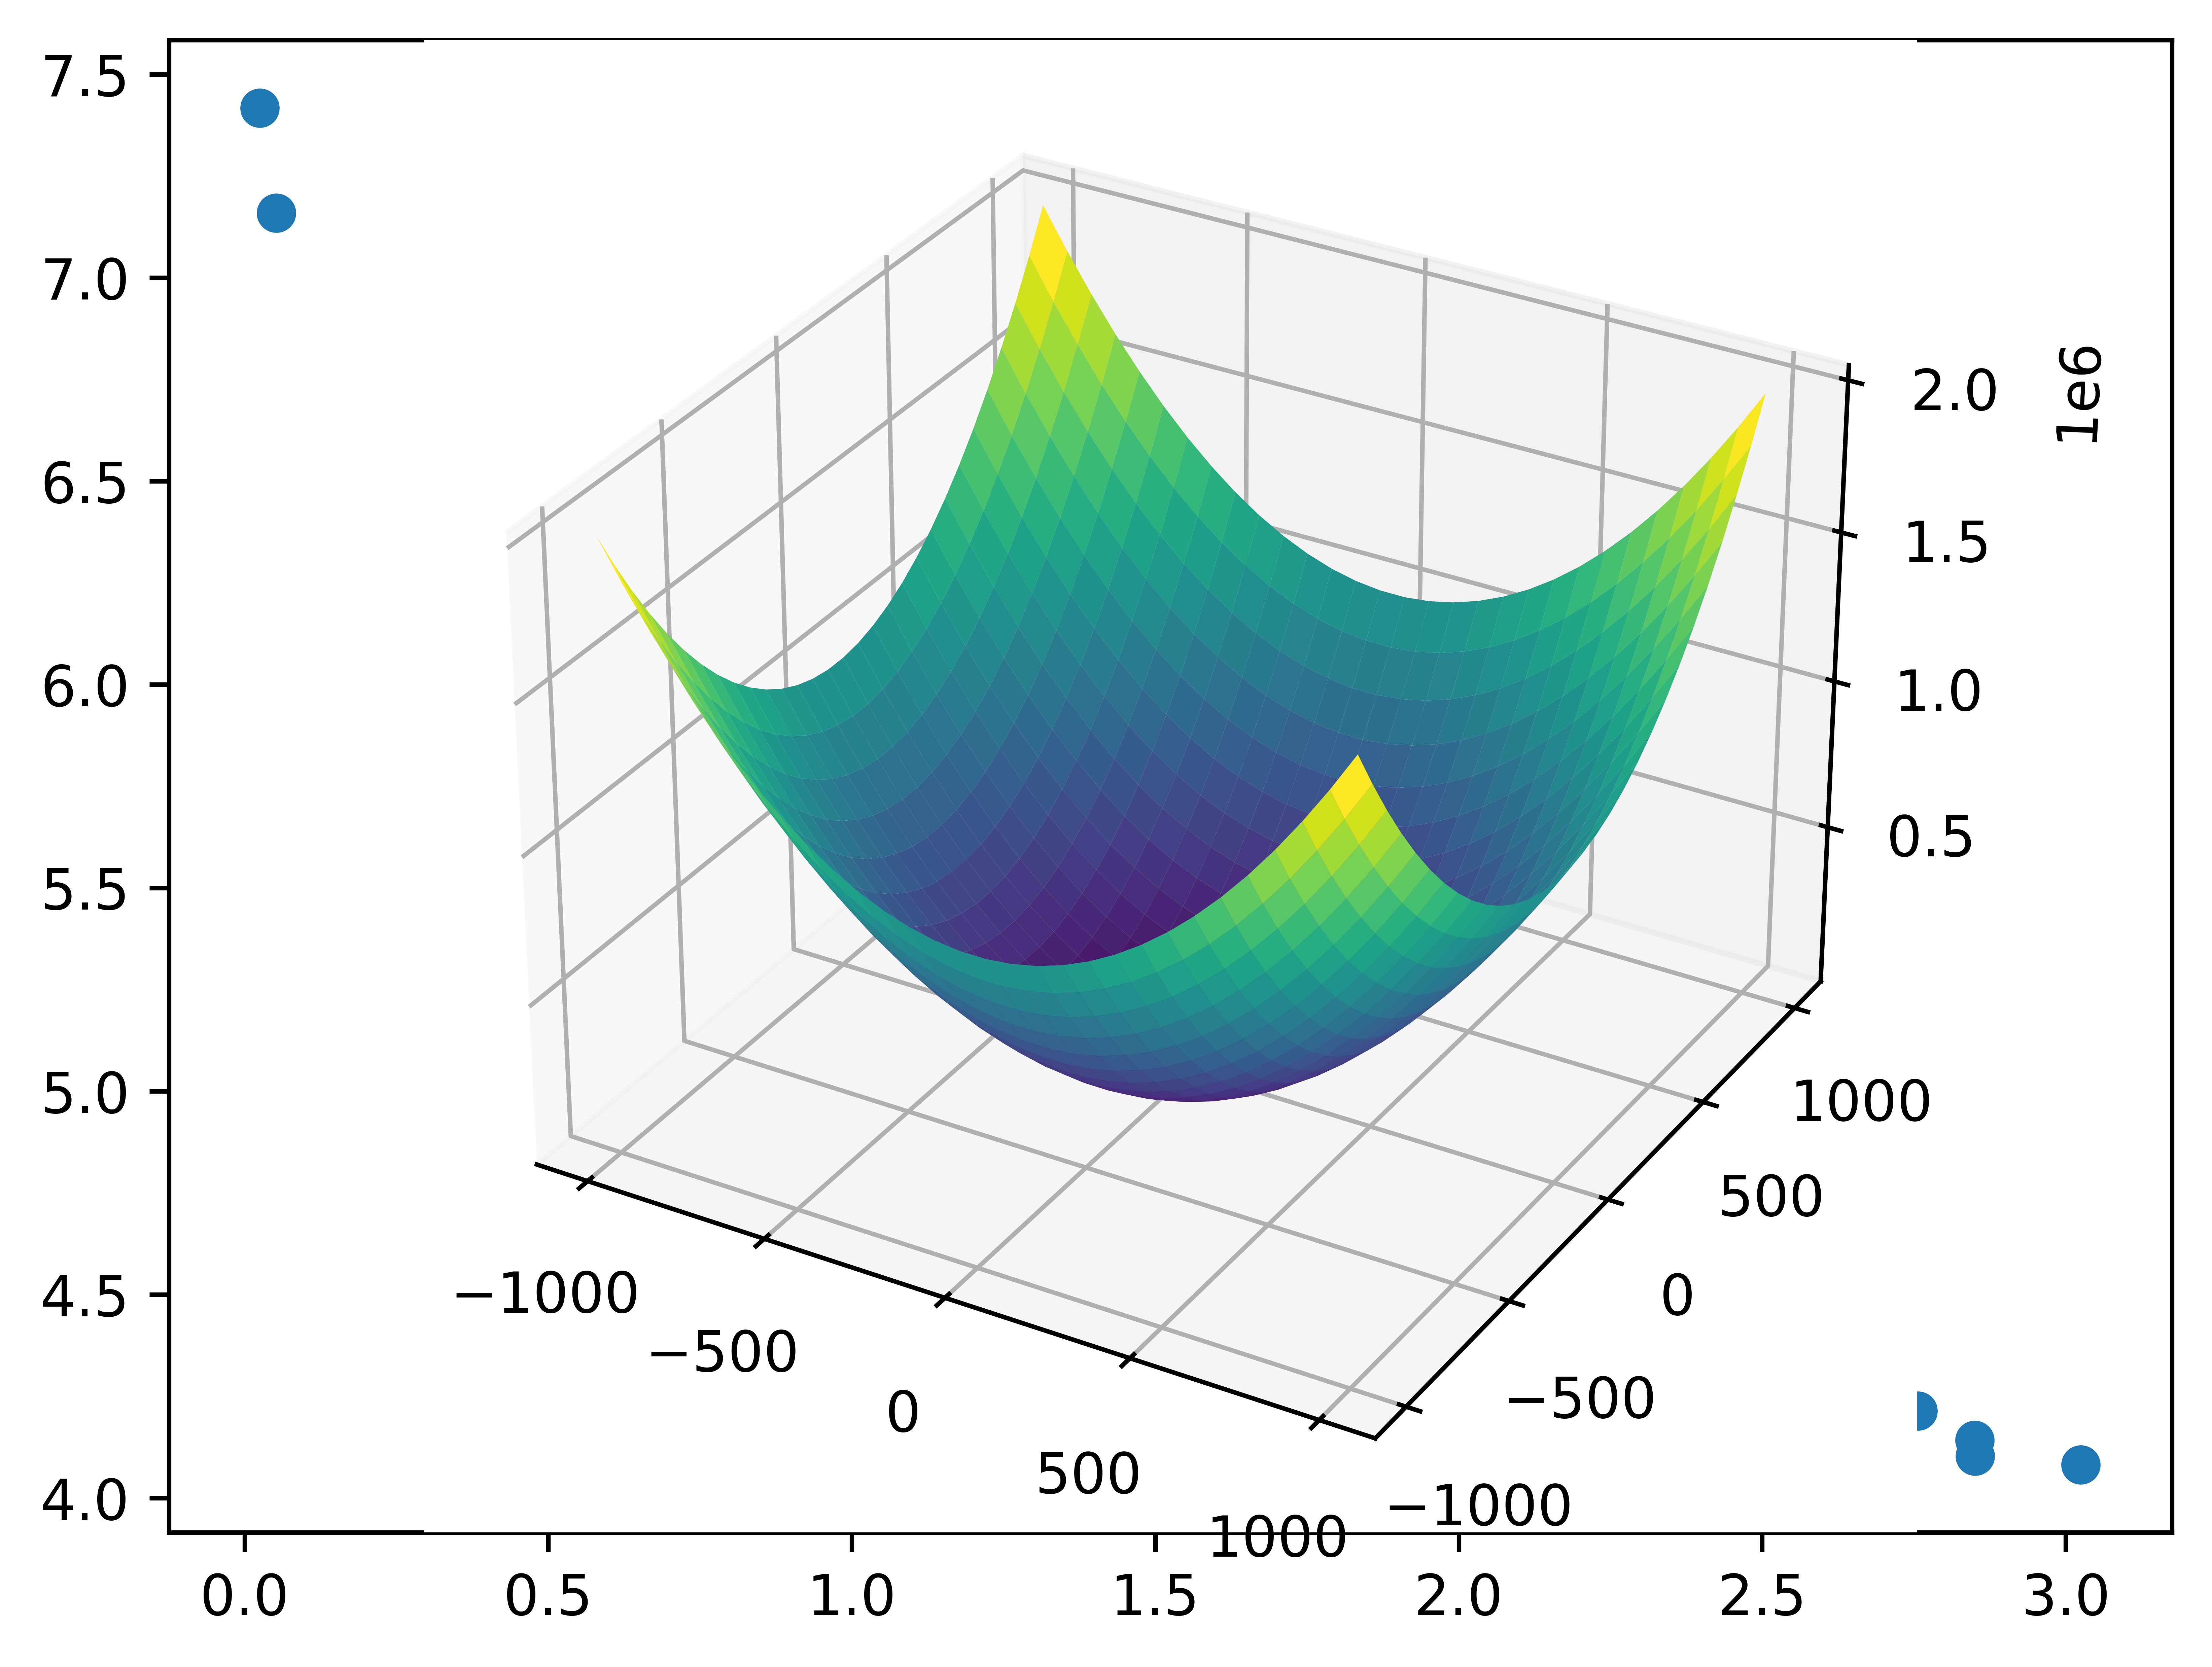

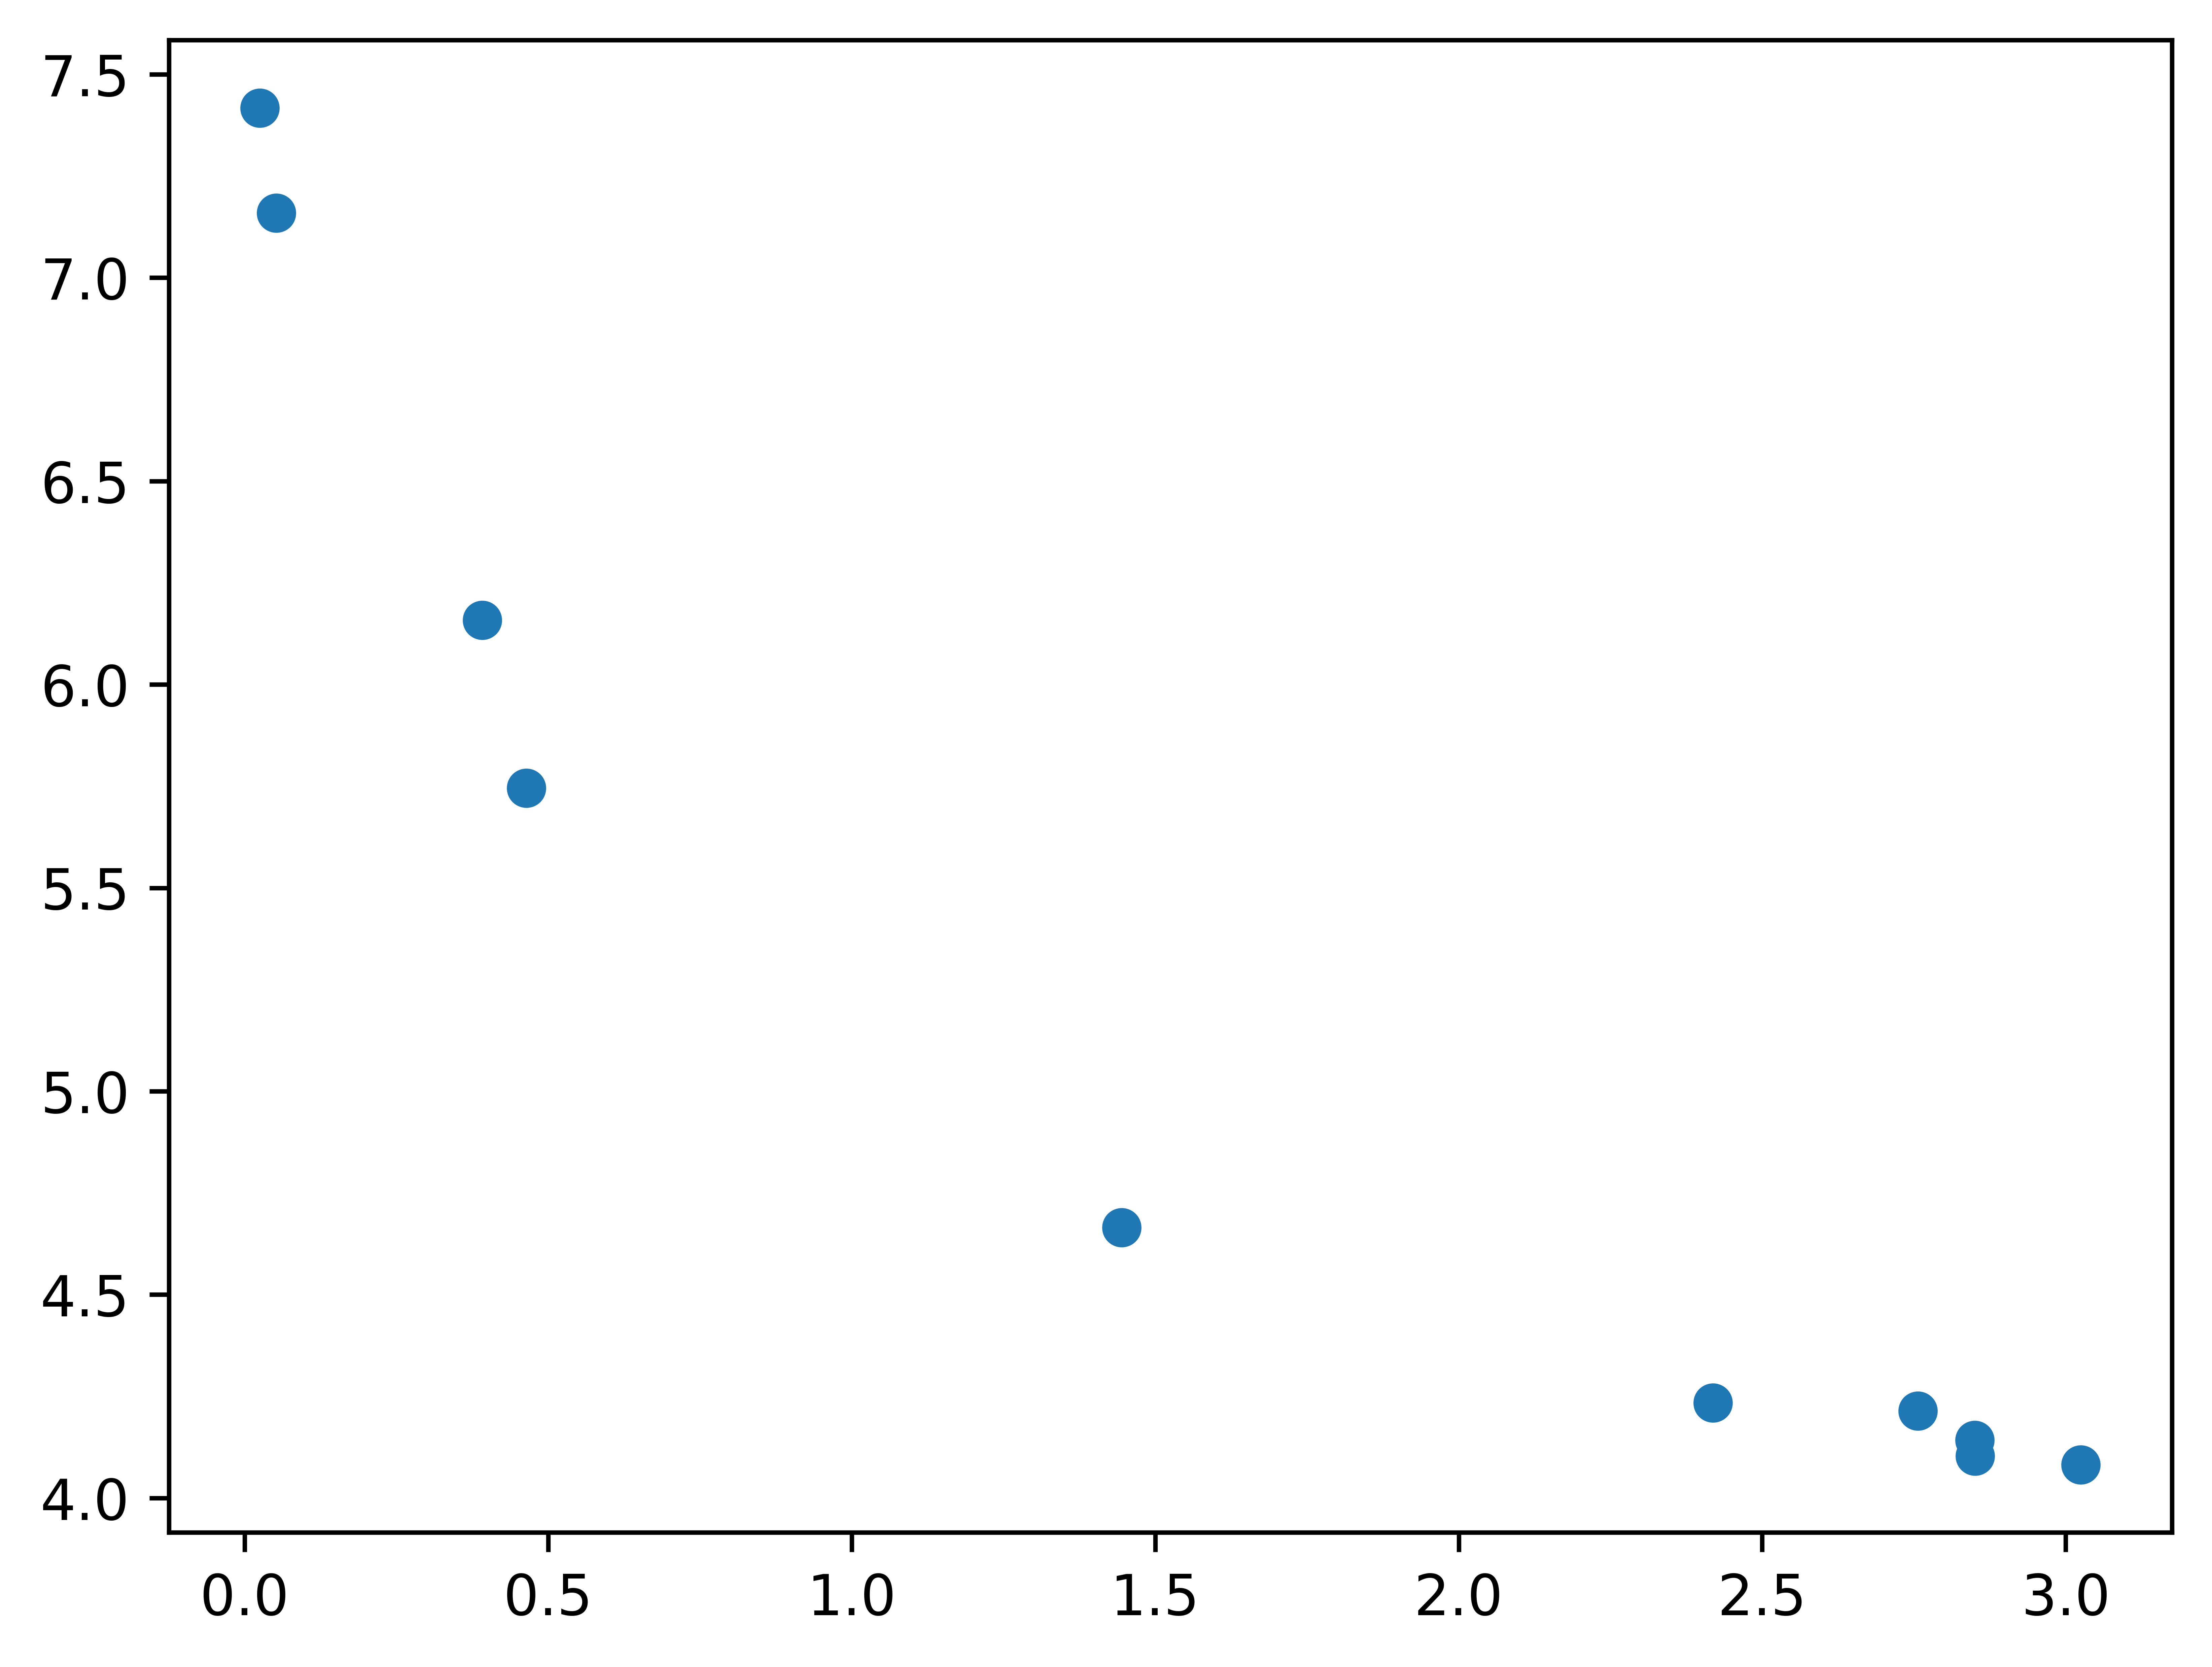

In [31]:
for m in M:
    plot_landscape(m, B)
    plot_front(gP_a)
    report_front(gP_a, cT, P_a, B, D, I)